### TAKE OUT 80 IMAGES FROM BLACK AND ORANGE CARS (ENDED UP DOING THIS SELECTION BY HAND BUT USED THE FUNCTION TO COLLECT ARRAYS)

In [2]:
import os
import shutil

def select_and_save_images(directory_path, output_image_path, output_npy_path, npy_directory_path, name):
    """
    Selects 'num_files' number of image files from the given directory in equal intervals.
    The selected image files are saved to one directory, and the corresponding '.npy' files
    are matched with the image files and saved to another directory.

    Parameters:
    - directory_path: Path to the directory containing the image files.
    - output_image_path: Path to the directory where the selected image files will be stored.
    - output_npy_path: Path to the directory where the corresponding '.npy' files will be stored.
    - npy_directory_path: Path to the directory containing the '.npy' files.
    - num_files: Number of image files to select.

    Returns:
    - List of file names (without extensions) of the selected image files.
    """
    if not os.path.exists(output_image_path):
        os.makedirs(output_image_path)

    if not os.path.exists(output_npy_path):
        os.makedirs(output_npy_path)

    file_list = os.listdir(directory_path)
    image_extensions = ['.jpg', '.jpeg', '.png']  # Add other image extensions if needed

    image_files = [file for file in file_list if any(file.lower().endswith(ext) for ext in image_extensions)]
    image_files.sort()  # Sort image files for consistency

    total_files = len(image_files)

    selected_image_files = []

    for i in range(0, total_files):
        file_name, file_extension = os.path.splitext(image_files[i])
        selected_image_files.append(file_name)

        # Save selected image files
        image_file_path = os.path.join(directory_path, image_files[i])
        output_image_file_path = os.path.join(output_image_path, name + image_files[i])
        shutil.copy(image_file_path, output_image_file_path)

        # Matching with corresponding '.npy' files and save
        npy_file_path = os.path.join(npy_directory_path, name + file_name + ".npy")
        # Assuming there is a corresponding '.npy' file for each image
        # Replace this with the actual path or logic to get '.npy' files
        shutil.copy(npy_file_path, os.path.join(output_npy_path, name + file_name + ".npy"))

    return selected_image_files

black_path = "./data/carseg_data/selected_images/black_ims"
orange_path = "./data/carseg_data/selected_images/orange_ims"
photos_path = "./data/carseg_data/selected_images/photos"

output_path = "./data/carseg_data/clean_arrays"
output_im_path = "./data/carseg_data/clean_arrays_images"

npy_directory_path = "./data/carseg_data/unused/arrays"

selected_image_files = select_and_save_images(black_path, output_im_path, output_path, npy_directory_path, "black_5_doors_")
selected_image_files = select_and_save_images(orange_path, output_im_path, output_path, npy_directory_path, "orange_3_doors_")
selected_image_files = select_and_save_images(photos_path, output_im_path, output_path, npy_directory_path, "photo_")

print("Selected image files:", selected_image_files)


FileNotFoundError: [WinError 3] The system cannot find the path specified: './data/carseg_data/selected_images/black_ims'

### COLLECT THE SEGMENTED IMAGES TO BE USED TO MAKE BETTER MASKS

In [ ]:
import os
import re
import shutil

def extract_number_from_filename(filename):
    # Use regular expression to extract a 4-digit number from the filename
    match = re.search(r'\b(\d{4})\b', filename)
    if match:
        return match.group(1)
    return None

def find_and_copy_files(source_dir, search_dir, destination_dir):
    # Get a list of filenames in the source directory
    source_filenames = os.listdir(source_dir)

    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Iterate through each filename in the source directory
    for filename in source_filenames:
        # Extract the 4-digit number from the filename in the source directory
        source_number = extract_number_from_filename(filename)

        if source_number:
            # Search for files in the search directory that have the same 4-digit number
            matching_files = [f for f in os.listdir(search_dir) if extract_number_from_filename(f) == source_number]

            if matching_files:
                # Construct the full path for the first matching file in the search directory
                search_filepath = os.path.join(search_dir, matching_files[0])

                # Construct the full path for the destination file
                destination_filepath = os.path.join(destination_dir, filename)

                # Copy the file from the search directory to the destination directory
                shutil.copyfile(search_filepath, destination_filepath)

                print(f"File '{filename}' copied from '{search_dir}' to '{destination_dir}'")


# Example usage:
source_directory = './data/carseg_data/selected_images/black_ims'
search_directory = './data/carseg_data/unused/images/black_5_doors/with_segmentation'
destination_directory = './data/carseg_data/selected_images/black_ims_segmented'

find_and_copy_files(source_directory, search_directory, destination_directory)


# Example usage:
source_directory = './data/carseg_data/selected_images/orange_ims'
search_directory = './data/carseg_data/unused/images/orange_3_doors/with_segmentation'
destination_directory = './data/carseg_data/selected_images/orange_ims_segmented'

find_and_copy_files(source_directory, search_directory, destination_directory)

# Example usage:
source_directory = './data/carseg_data/selected_images/photos'
search_directory = './data/carseg_data/unused/images/photo/with_segmentation'
destination_directory = './data/carseg_data/selected_images/photos_segmented'

find_and_copy_files(source_directory, search_directory, destination_directory)


### MAKE BETTER MASKS FROM SEGMENTED IMAGES

In [1]:
import os
import numpy as np
import cv2
from random import choice

def replace_backgrounds_with_condition(input_folder, mask_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List all npy files in the input folder
    npy_files = [f for f in os.listdir(input_folder) if f.endswith('.npy')]

    for npy_file in npy_files:
        # Load the numpy array
        npy_path = os.path.join(input_folder, npy_file)
        img_array = np.load(npy_path)

        # Load the greyscale mask image
        mask_file = os.path.join(mask_folder, npy_file.replace('.npy', '.png'))
        print(mask_file)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
        for i in range(1,9):
            img_array[img_array[:, :, 3] == 10 * i, 3] = 0
        img_array[img_array[:, :, 3] == 90, 3 ] = 9
        
        # Iterate through the mask image
        for i in range(img_array.shape[0]):
            for j in range(img_array.shape[1]):
                if mask[i, j] != 0:
                    if img_array[i, j, 3] != 9:
                        img_array[i, j, 3] = mask[i, j]

        # Save the modified numpy array to the output folder
        output_path = os.path.join(output_folder, f"{npy_file}")
        np.save(output_path, img_array)

arrays = "./data/carseg_data/test_arrays"
masks = "./data/dataset_256_256/test/labels"
output = "./data/carseg_data/test_arrays_mask_corrected"

replace_backgrounds_with_condition(arrays, masks, output)


./data/dataset_256_256/test/labels/photo_0027.png
./data/dataset_256_256/test/labels/photo_0026.png
./data/dataset_256_256/test/labels/photo_0024.png
./data/dataset_256_256/test/labels/photo_0030.png
./data/dataset_256_256/test/labels/photo_0018.png
./data/dataset_256_256/test/labels/photo_0019.png
./data/dataset_256_256/test/labels/photo_0025.png
./data/dataset_256_256/test/labels/photo_0009.png
./data/dataset_256_256/test/labels/photo_0021.png
./data/dataset_256_256/test/labels/photo_0020.png
./data/dataset_256_256/test/labels/photo_0008.png
./data/dataset_256_256/test/labels/photo_0022.png
./data/dataset_256_256/test/labels/photo_0023.png
./data/dataset_256_256/test/labels/photo_0012.png
./data/dataset_256_256/test/labels/photo_0006.png
./data/dataset_256_256/test/labels/photo_0007.png
./data/dataset_256_256/test/labels/photo_0013.png
./data/dataset_256_256/test/labels/photo_0005.png
./data/dataset_256_256/test/labels/photo_0011.png
./data/dataset_256_256/test/labels/photo_0010.png


### AUGMENT INTO A BIGGER DATASET

In [12]:
import torch
import torchvision.transforms as T
import random
from modules.settings import MEAN, STD
import os
import shutil

# Helper function to copy arrays of orange_3_doors and blaack_5_doors into out final data folder
def copy_orangeBlack_files(source_directory, destination_directory, keywords):
    # keywords = ['orange', 'black']
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    # Iterate through files in the source directory
    for filename in os.listdir(source_directory):
        if filename.lower().endswith('.npy'):
            file_path = os.path.join(source_directory, filename)

            # Check if the file contains any of the specified keywords
            if any(keyword in filename.lower() for keyword in keywords):
                # Copy the file to the destination directory
                shutil.copy(file_path, os.path.join(destination_directory, filename))

def addnoise(input_image, noise_factor_range=(0.1, 0.4)):
    # Randomly select noise factor from the specified range
    noise_factor = random.uniform(noise_factor_range[0], noise_factor_range[1])

    inputs = T.ToTensor()(input_image)
    noise = inputs + torch.rand_like(inputs) * noise_factor
    noise = torch.clip(noise, 0, 1.)

    output_image = T.ToPILImage()
    noisy_image = output_image(noise)
    noise_factor = "{:.3f}".format(noise_factor)

    return noisy_image, noise_factor

def normalize_image(pil_image):
    # Convert PIL image to a PyTorch tensor
    tensor_image = T.ToTensor()(pil_image)

    # Normalize the tensor
    normalized_tensor = T.Normalize(MEAN, STD)(tensor_image)

    # Convert the normalized tensor back to a PIL image
    normalized_pil_image = T.ToPILImage()(normalized_tensor)

    return normalized_pil_image


In [8]:
import numpy as np
from PIL import Image, ImageDraw
from torchvision import transforms
import random

def h_flip(image_array, mask_array):
    # Convert the image array to a PIL image
    original_image = Image.fromarray(np.uint8(image_array))

    # Perform vertical flip on the image
    flipped_image = transforms.functional.hflip(original_image)

    # Convert the flipped image back to an array
    flipped_image_array = np.array(flipped_image)
  
    flipped_mask_array = np.fliplr(mask_array)
    # Expand mask dim to concatinate it with photo
    flipped_mask_array = np.expand_dims(flipped_mask_array, axis=-1)

    # Concatenate the 4th channel to the augmented image
    flipped_array = np.concatenate((flipped_image_array, flipped_mask_array), axis=-1)
    
    return flipped_array

def v_flip(image_array, mask_array):
    # Convert the image array to a PIL image
    original_image = Image.fromarray(np.uint8(image_array))

    # Perform vertical flip on the image
    flipped_image = transforms.functional.vflip(original_image)

    # Convert the flipped image back to an array
    flipped_image_array = np.array(flipped_image)

    flipped_mask_array = np.flipud(mask_array)
    # Expand mask dim to concatenate it with photo
    flipped_mask_array = np.expand_dims(flipped_mask_array, axis=-1)

    # Concatenate the 4th channel to the augmented image
    flipped_array = np.concatenate((flipped_image_array, flipped_mask_array), axis=-1)

    return flipped_array

def add_black_squares(image, mask, square_size, num_squares, probability=0.4):
    # Convert the image to RGB mode if it's not already
    image = image.convert('RGB')

    # Check if the transformation should be applied based on probability
    if random.random() > probability:
        return image, mask

    # Create a drawing object
    draw = ImageDraw.Draw(image)

    # Get the dimensions of the image
    width, height = image.size

    for _ in range(num_squares):
        # Randomly generate the position of the top-left corner of the square
        top_left_x = random.randint(0, width - square_size)
        top_left_y = random.randint(0, height - square_size)

        # Draw a black square on the image
        bottom_right_x = top_left_x + square_size
        bottom_right_y = top_left_y + square_size
        draw.rectangle([top_left_x, top_left_y, bottom_right_x, bottom_right_y], fill="black")

        # Apply the same square to the mask
        mask[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 0
    
    return image, mask


In [11]:
import os
import numpy as np
from torchvision import transforms
from PIL import Image


# Function to apply PyTorch transforms to an image
def apply_transforms(image, mask, transform):
    # Convert the image to a PIL Image
    pil_image = Image.fromarray(image)
    pil_image, noise_vactor = addnoise(pil_image)
    pil_image, transformed_mask = add_black_squares(pil_image, mask, square_size=35, num_squares=2, probability=0.30)
    
    # Apply the transforms
    transformed_image = transform(pil_image)

    # Convert the transformed image back to a numpy array
    transformed_image = np.array(transformed_image)

    return transformed_image, transformed_mask

# Function to perform augmentation on images with "photo" in their filename
def augment_images(input_folder, output_folder_images, output_folder_arrays, num_augmentations=7):
    # Create output folders if they don't exist
    for folder in [output_folder_images, output_folder_arrays]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Define PyTorch transforms for augmentation
    transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.GaussianBlur(kernel_size=3),
    ])

    # Iterate through files in the input folder
    for filename in os.listdir(input_folder):
        if "photo" in filename.lower() and filename.endswith(".npy"):
            # Load the image from the npy file
            image = np.load(os.path.join(input_folder, filename))

            # Select only the first three channels (RGB)
            image_rgb = image[..., :3]

            # Select the mask 
            mask = image[:, :, 3]

            # Flip horizontaly 
            array_h_flipped = h_flip(image_rgb, mask)
            # Save the h_flipped array
            flipped_output_path_array = os.path.join(output_folder_arrays, f"Hflip_{filename}")
            np.save(flipped_output_path_array, array_h_flipped)

            # Flip vertically
            array_v_flipped = v_flip(image_rgb, mask)
            # Save the v_flipped array
            flipped_output_path_array = os.path.join(output_folder_arrays, f"Vflip_{filename}")
            np.save(flipped_output_path_array, array_v_flipped)

            # Save the original array
            original_output_path_array = os.path.join(output_folder_arrays, f"original_{filename}")
            np.save(original_output_path_array, image)

            # Save the original image
            original_output_path_image = os.path.join(output_folder_images, f"original_{filename.replace('.npy', '.png')}")
            Image.fromarray(image_rgb.astype('uint8')).save(original_output_path_image)

            # Augment the image multiple times
            for i in range(num_augmentations):
                # Apply transforms
                augmented_image, augmented_mask = apply_transforms(image_rgb, mask, transform)
 
                # Expand mask dim to concatenate it with photo
                augmented_mask = np.expand_dims(augmented_mask, axis=-1)

                # Concatenate the 4th channel to the augmented image
                augmented_array = np.concatenate((augmented_image, augmented_mask), axis=-1)

                # Save the augmented image
                augmented_output_path_image = os.path.join(output_folder_images, f"augmented_{i}_{filename.replace('.npy', '.png')}")
                Image.fromarray(augmented_image.astype('uint8')).save(augmented_output_path_image)

                # Save the augmented and concatenated array
                augmented_output_path_array = os.path.join(output_folder_arrays, f"augmented_{i}_{filename}")
                np.save(augmented_output_path_array, augmented_array)

# Example usage:
oarnge_black_arrays_path = './data/carseg_data/clean_arrays_mask_corrected'
input_folder = './data/carseg_data/clean_arrays_mask_corrected'
output_folder_images = './data/carseg_data/FINAL_select_augmented_images'
output_folder_arrays = './data/carseg_data/FINAL_select_augmented_arrays'

augment_images(input_folder, output_folder_images, output_folder_arrays)
print("Augmentation done.")
copy_orangeBlack_files(oarnge_black_arrays_path,output_folder_arrays, ['orange', 'black'])
print("All files colleced now.")

Augmentation done.
All files colleced now.


In [28]:
import os

def count_items_in_folder(folder_path):
    total_items = 0
    images_0150_count = 0

    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)

        if os.path.isfile(item_path):
            total_items += 1

            if item.lower().endswith("0150.png"):
                images_0150_count += 1

    return total_items, images_0150_count

# Example usage:
folder_path = "./data/carseg_data/FINAL_select_augmented_images"
total_items, images_0150_count = count_items_in_folder(folder_path)

print(f'Total items in the folder: {total_items}')
print(f'Number of images ending with "*0150.png": {images_0150_count}')


Total items in the folder: 904
Number of images ending with "*0150.png": 8


### CHECK THE IMAGES AND THE MASKS

In [16]:
import matplotlib as plt
import matplotlib.pyplot as plt
import os
import random
import numpy as np

mask_path = "./data/carseg_data/FINAL_select_augmented_arrays"

# Define color mapping for each class
color_mapping = {
        0: (0,0,0),
        1: (250, 149, 10),
        2: (19, 98, 19),
        3: (249, 249, 10),
        4: (10, 248, 250),
        5: (149, 7, 149),
        6: (5, 249, 9),
        7: (20, 19, 249),
        8: (249, 9, 250),
        9: (150, 150, 150),
    }

def colorize_segmentation_mask(segmentation_tensor_or_mask, mask = False):
    # Convert the PyTorch tensor to a NumPy array
    if mask == False:
        segmentation_array = segmentation_tensor_or_mask.squeeze(0).cpu().numpy()
        
    else:
        segmentation_array = segmentation_tensor_or_mask

    # Create a mapping from actual class values to color values
    class_to_color = {class_value: color_mapping[class_value] for class_value in np.unique(segmentation_array)}

    # Create an RGB image with the colored segmentation mask
    colored_mask = np.zeros((256, 256, 3), dtype=np.uint8)
    for class_value, color in class_to_color.items():
        colored_mask[segmentation_array == class_value] = color

    return colored_mask

def display_random_photos(mask_path, num_photos=10):
    index = 0
    image_files = os.listdir(mask_path)
    random.shuffle(image_files)

    for im in image_files:
        mask_p = os.path.join(mask_path, im)
        mask = np.load(mask_p)
        mask_split = mask[:, :, 3]
        mask_split = mask_split.astype(int)
        print(np.unique(mask_split))
        
        img = mask[:, :, :3]
        
        plt.subplot(1, 3, 1)
        plt.imshow(colorize_segmentation_mask(mask_split, True))
        plt.title('Ground Truth Mask')

        plt.subplot(1, 3, 2)
        plt.imshow(img)
        
        plt.show()

        index += 1
        if index == num_photos:
            break

[0 1 2 4 5 7 8 9]


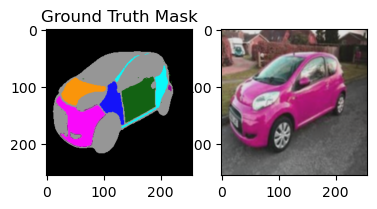

[0 1 2 5 8 9]


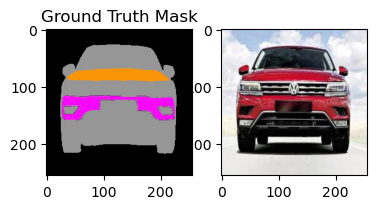

[0 1 2 3 4 5 7 8 9]


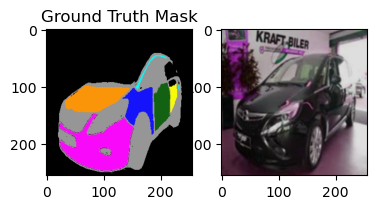

In [11]:
mask_path = "./data/carseg_data/FINAL_select_augmented_arrays"
display_random_photos(mask_path, num_photos=3)